# **Restauro zero-shot con demucs degli audio di Musicgen**

I modelli audio generativi producono spesso output con una qualità sonora inferiore agli standard professionali. L'obiettivo di questo progetto è l'implementazione di una pipeline di restauro che usi un approccio zero-shot basata su demucs. Il progetto si concentra sull'analisi spettrale e percettiva del miglioramento ottenuto.


Installazione delle librerie e dipendenze necessarie

In [4]:
!pip -q install --upgrade transformers accelerate scipy soundfile

import torch, numpy as np, os, shutil, librosa, soundfile as sf
from pathlib import Path
from scipy.signal import butter, lfilter, resample_poly
from scipy.io.wavfile import write
import numpy as np, librosa, librosa.display, matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import soundfile as sf

print("Installazioni completate. Riavvia il runtime se richiesto (in alcuni ambienti).")


Installazioni completate. Riavvia il runtime se richiesto (in alcuni ambienti).


## **1. Funzioni utili per la gestione di file e file audio:**

*   ***ensure_dir(p: Path)***: questa funzione verifica se un path di directory esiste, altrimenti lo crea;
*   ***valid_audio(x: np.ndarray)***: questa funzione svolge una serie di controlli per controllare un array NumPy:

      *   Verifica dell'input;
      *   Controllo dell'audio: mono o stereo;
      *   Controllo dei valori speciali (NaN o Inf);
      *   Verifica che l'array non sia vuoto.
* ***save_wav_safe(path: Path, audio: np.ndarray, sr: int)*** : questa funzione salva il file WAV nel path specifico con una frequenza di campionamento (sr). Previene la distorsione applicando np.clip e limitando i valori.
* ***load_mono(path: Path, sr: int)***: questa funzione carica un file audio da un path usando Librosa e si assicura della conversione e del ricampionamento con la giusta frequenza di campionamento (sr).

In [5]:
warnings.filterwarnings("ignore")

def ensure_dir(p: Path):  # Questa funzione prende in input un percorso e si assucura che esista.
    p.mkdir(parents=True, exist_ok=True)

def valid_audio(x: np.ndarray): # Questa funzione controlla la qualità dell'audio, evitando così che entrino file corrotti ella p
    return (
        isinstance(x, np.ndarray) # Controlla se l'array è un array NumPy
        and x.ndim in (1,2) # Controlla se l'audio è mono 1D o stereo 2D
        and np.isfinite(x).all() # Controlla se nell'array ci sono numeri particolari come NaN e infinito
        and len(x) > 0 # Controlla se l'array è vuoto
        and np.max(np.abs(x)) > 0 # Controlla se l'audio è completamente silenzioso
    )

def save_wav_safe(path: Path, audio: np.ndarray, sr: int): # Questa funzione salva il file wav
    if audio.ndim == 1:
        audio = audio[:, None]
    audio = np.clip(audio, -1.0, 1.0) # In questa riga il segnale audio che è più forte di 1.0 e più debole di -1.0 viene tagliato, per prevenire il clipping (distorsione)
    sf.write(str(path), audio, sr, subtype='PCM_16') # Il file viene salvato a 16bit

def load_mono(path: Path, sr: int): # Questa funzione carica un file audio usando librosa
    x, sr0 = librosa.load(str(path), sr=sr, mono=True) # assicurandosi che l'audio sia convertito in mono e con la giusta frequenza
    return x, sr



## **2. Generazione degli input con Musicgen**

Il processo di creazione dell'audio musicale con Musicgen si divide in:
1. Caricamento del modello e del suo processore, dopo ave scelto il tipo di device da utilizzare;
2. Creazione dei prompt testuali che descrivono uno stile musicale;
3. Conversione del prompt testuale in token audio;
4. Decodifica dei token per la conversione nell'estensione audio .WAV.


In [7]:

from transformers import AutoProcessor, MusicgenForConditionalGeneration

device = "cuda" if torch.cuda.is_available() else "cpu" # Imposto il dispositivo per l'elaborazione
model_id = "facebook/musicgen-small"  # Specifico l'ID del modello, caricato da hugging face

processor = AutoProcessor.from_pretrained(model_id) # Carico il processore che converte i prompt testuali in token
model = MusicgenForConditionalGeneration.from_pretrained(model_id).to(device) # Carico l'architettura del modello

prompts = [
    "funky jazz with walking bass and brushed drums, warm and vintage",
    "ambient electronic pads with soft arpeggios, spacious and airy",
    "distorted indie rock riff with punchy drums, energetic"
] # Inserisco i prompts (possono essere aggiunti)

sr_mg = 32000 # Sample rate: frequenza di campionamento in Hz
gen_secs = 5  # durata per ogni audio generato (può essre aumentata)

musicgen_dir = Path("audio_dataset/musicgen_raw") # Delineo il path dove andrò a salvare le canzoni generate da musicgen
ensure_dir(musicgen_dir)

generated_paths = []

for i, text in enumerate(prompts): # Itero su ogni prompt nella lista prompts
    inputs = processor(text=[text], padding=True, return_tensors="pt").to(device) # Elaboro il prompt in tensori
        tokens = model.generate(
            **inputs,
            do_sample=True,
            guidance_scale=3.0, # Bilancio la fedeltà al prompt
            max_new_tokens=gen_secs * 50  # ≈ 50 token/sec @32kHz
        )
    audios = processor.batch_decode(tokens, audio_format="wav") # Converto i token ottenuti in un segnale audio -> array numpy
    wav = np.array(audios[0][0], dtype=np.float32)  # mono @32k
    out = musicgen_dir / f"musicgen_{i:02d}.wav" # Creo un nome per i file in modo progressivo
    sf.write(out, wav, sr_mg, subtype='PCM_16') #Salvo l'array in formato WAV
    generated_paths.append(str(out))

print(f"Generati {len(generated_paths)} file da MusicGen in: {musicgen_dir.resolve()}")


[OK] Generati 3 file da MusicGen in: /content/audio_dataset/musicgen_raw


## **3. Applicazione di Demucs ai file generati da Musicgen**


In [11]:
mg_restored_dir = Path("restored_outputs"); ensure_dir(mg_restored_dir)
musicgen_files = list(Path("audio_dataset/musicgen_raw").glob("*.wav")) # Prendo tutti i file che hanno l'estensione .WAV in quel path
mg_records = []

for p in musicgen_files: # Per ogni audio generato da musicgenm
    restored = enhance_with_demucs(str(p), output_dir=str(mg_restored_dir)) # prrendo il path del file input e della cartella di output, eseguo demucs e salvo il file nella cartella dei file restaurati
    mg_records.append({"file": str(p), "restored": restored})

print("Restauro completato per tutti i file .WAV generati da MusicGen.")


[Demucs] musicgen_00
[Demucs] musicgen_01
[Demucs] musicgen_02
[OK] Restauro completato per MusicGen.



## **4. Analisi spettrale (plot Mel) — MusicGen (input vs Demucs)**
Con questa funzione visualizziamo gli spettrogrammi in scala Mel degli audio:
* Generati da musicgen:;
* Restaurati, nel quale notiamo il recupero delle alte frequenze ma una leggera difficoltà nel restaurare le basse frequenze, soprattutto con file audio musicali molto complessi.



MUSICGEN: musicgen_00.wav


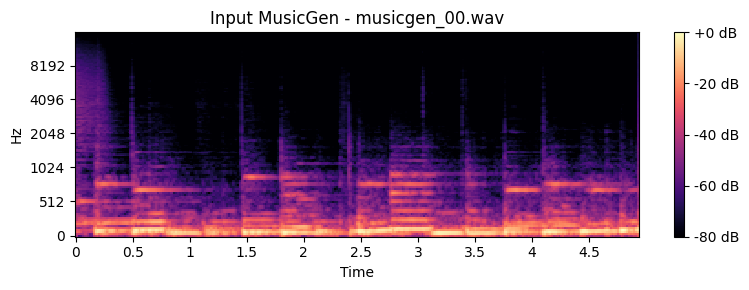

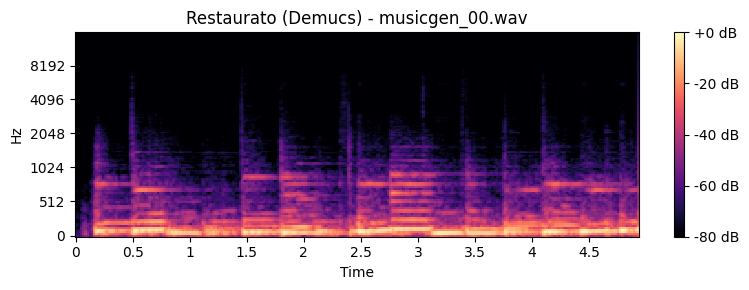

MUSICGEN: musicgen_01.wav


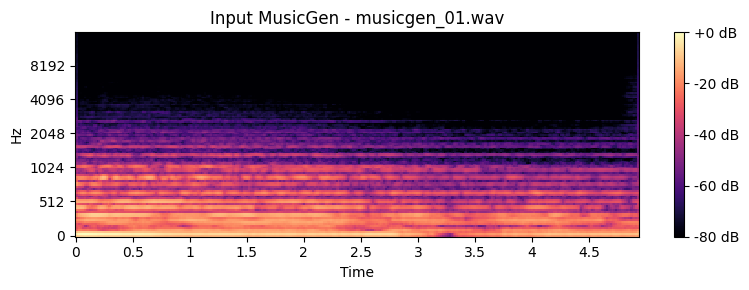

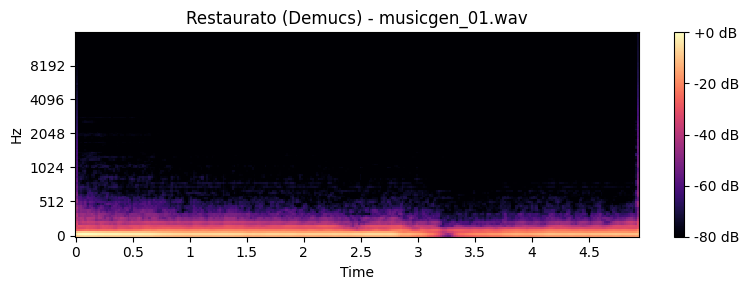

MUSICGEN: musicgen_02.wav


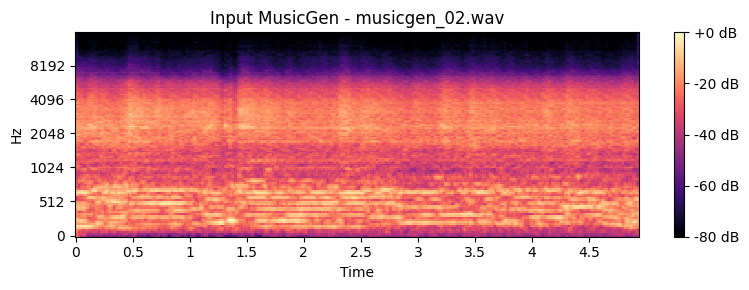

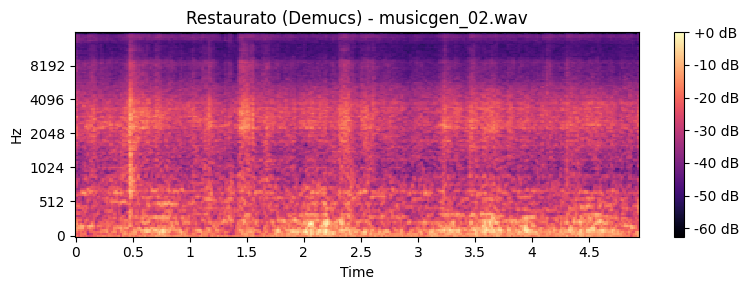

In [12]:
def plot_spectrogram(filepath, title):
    if not filepath or not Path(filepath).exists(): # Controllo dell'esistenza del path
        print(f"File non trovato per il plot: {title}")
        return
    try:
        y, sr = librosa.load(filepath, sr=32000)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=16000)
        S_dB = librosa.power_to_db(S, ref=np.max)
        fig, ax = plt.subplots(figsize=(8, 3))
        img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=16000, ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        ax.set_title(title)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Errore durante lo spettrogramma per {title}: {e}")

for rec in mg_records:
    print("="*60)
    print("MUSICGEN:", Path(rec["file"]).name)
    plot_spectrogram(rec["file"],   f"Input MusicGen - {Path(rec['file']).name}")
    plot_spectrogram(rec["restored"], f"Restaurato (Demucs) - {Path(rec['file']).name}")


## **5. Proxy metriche per MusicGen (input vs Demucs)**
Nella cella che segue andiamo a definire tutte le funzioni per le metriche proxy:


*   ***band_energy(x, sr, f_low, f_high, n_fft=2048, hop=512)***: calcola lo spettrogramma di potenza, crea una lista di frequenze basate sullo spettrogramma e selziona solo le frequenze nella banda desiderata. Restituisce l'energia media della banda di frequenza.
*   ***highband_energy_gain(x_in, x_out, sr=32000, f_cut=7000)***: calcola la variazione di energia nelle alte frequenze dopo l'elaborazione, calcolando il rapporto di energia tra input e output in db.
* ***spectral_flatness_mean(x, sr, n_fft=2048, hop=512)***: questa funzione misura il rapporto tra le componenti tonali e i rumori del suono.
* ***silence_noise_floor(x, sr, thresh_db=-45)*** : questa funzione stima il livello medio di rumore nei segmenti silenziosi dell'audio. Calcola inizialmente l'energia Root Mean Square e trova tutti i frame che si trovano sotto la soglia del silenzio (-45dB) e in questi frame restituisce il livello medio di rumore in dB.



In [30]:
# Questa funzione calcola l'energia media in una specifica banda di frequenza.
def band_energy(x, sr, f_low, f_high, n_fft=2048, hop=512):
    S = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop))**2  # Calcola lo spettrogramma di potenza
    freqs = np.linspace(0, sr/2, S.shape[0])  # Crea una lista di frequenze che corrisponde alle righe dello spettrogramma
    band = (freqs >= f_low) & (freqs < f_high)  # Crea una maschera per selezionare solo le frequenze all'interno della banda desiderata
    return S[band, :].mean()  # Restituisce l'energia media della banda di frequenza selezionata su tutti gli intervalli temporali

 # Misura la variazione di energia nelle alte frequenze dopo l'elaborazione.
def highband_energy_gain(x_in, x_out, sr=32000, f_cut=7000):
    e_in = band_energy(x_in, sr, f_cut, sr/2)  # Calcola l'energia del segnale di input al di sopra della frequenza di taglio
    e_out = band_energy(x_out, sr, f_cut, sr/2)  # Calcola l'energia del segnale di output al di sopra della frequenza di taglio
    return 10*np.log10((e_out + 1e-12) / (e_in + 1e-12))  # Calcola il rapporto di energia tra output e input in dB aggiungendo 1e-12 per evitare la divisione per zero.

# questa funzione misura il rapporto tra componenti tonali e rumore del suono.
def spectral_flatness_mean(x, sr, n_fft=2048, hop=512):
    S = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop))  # Calcola lo spettrogramma di magnitudine
    flat = librosa.feature.spectral_flatness(S=S)  # Calcola la piattezza spettrale per ogni frame temporale
    return float(np.mean(flat))  # Restituisce la piattezza spettrale

# questa funzione stima il livello medio di rumore durante gli intervalli silenziosi dell'audio
def silence_noise_floor(x, sr, thresh_db=-45):
    rms = librosa.feature.rms(y=x, frame_length=2048, hop_length=512)[0]  # Calcola l'energia RMS (Root Mean Square) per ogni frame audio
    rms_db = librosa.power_to_db(rms**2 + 1e-12, ref=np.max)  # Converte l'energia in decibel
    idx = rms_db < thresh_db  # Crea una maschera booleana per trovare i frame al di sotto della soglia di silenzio: -45dB
    if not np.any(idx):  # Controlla se sono stati trovati frame di silenzio
        return np.nan  # Se non viene trovato alcun frame di silenzio restituisce NaN
    return float(np.mean(rms_db[idx]))  # Se esistono frame di silenzio restituisce il livello medio in dB di tali frame

# Ciclo principale per calcolare le metriche proxy per il dataset:

proxy_rows = []  # Inizializza una lista vuota per memorizzare i risultati di ciascun file audio
for rec in mg_records:  # Itera su una lista di path
    if not rec["restored"]:  # Salta il record corrente se il percorso del file restaurato non esiste
        continue
    xin, sr = load_mono(Path(rec["file"]), 32000)  # Carica il file audio di input  assicurandosi che sia in mono e abbia la giusta frequenza di campionamento
    xout, _ = load_mono(Path(rec["restored"]), 32000)  # Carica il file audio restaurato
    n = min(len(xin), len(xout))  # Determina la lunghezza del segnale più corto tra i due
    xin, xout = xin[:n], xout[:n]  # Pone entrambi i segnali alla stessa lunghezza per poterli confrontare
    row = {  # Crea un dizionario per memorizzare i risultati delle metriche per il file corrente
        "file": Path(rec["file"]).name,  # Memorizza il nome del file
        "ΔHBER_dB": highband_energy_gain(xin, xout, sr=sr, f_cut=7000),
        "Flat_in": spectral_flatness_mean(xin, sr),
        "Flat_out": spectral_flatness_mean(xout, sr),
        "Noise_in_dB": silence_noise_floor(xin, sr),
        "Noise_out_dB": silence_noise_floor(xout, sr),
    }
    proxy_rows.append(row)

df_musicgen_proxy = pd.DataFrame(proxy_rows).round(3)  # Converte la lista di dizionari in un DataFrame di pandas e arrotonda i valori numerici
display(df_musicgen_proxy)  # Visualizza il DataFrame nell'output
df_musicgen_proxy.to_csv("results_musicgen_proxy.csv", index=False)  # Salva il DataFrame
print("Salvato: results_musicgen_proxy.csv")  # Stampa un messaggio di conferma.

,file,ΔHBER_dB,Flat_in,Flat_out,Noise_in_dB,Noise_out_dB
0,musicgen_00.wav,-11.090,0.000,0.000,NaN,-54.488
1,musicgen_01.wav,-4.229,0.000,0.000,NaN,NaN
2,musicgen_02.wav,-21.732,0.001,0.051,NaN,NaN


Salvato: results_musicgen_proxy.csv


## **5. Spectral Gating e delta spectogram**
In questa cella viene creata la tecnica di riduzione del rumore "Spectral gating". Viene calcolata la STFT del segnale audio e, dopo aver stimato la soglia di rumore e creato una maschera binaria, viene restituito il segnale "pulito".

[OK] Salvato: restored_outputs/delta_spectrograms/musicgen_00_delta_demucs.png


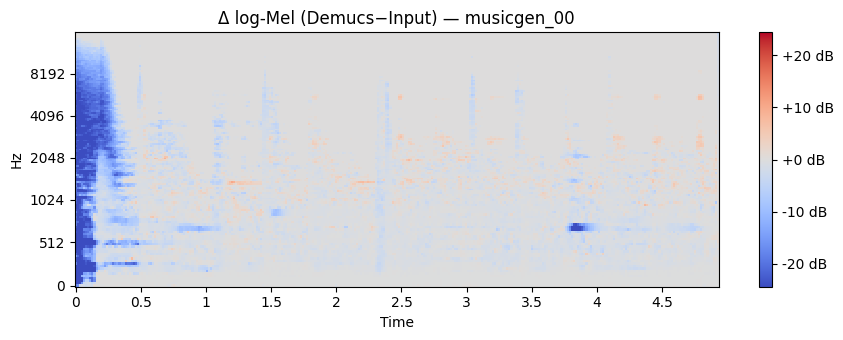

[OK] Salvato: restored_outputs/delta_spectrograms/musicgen_00_delta_gating.png


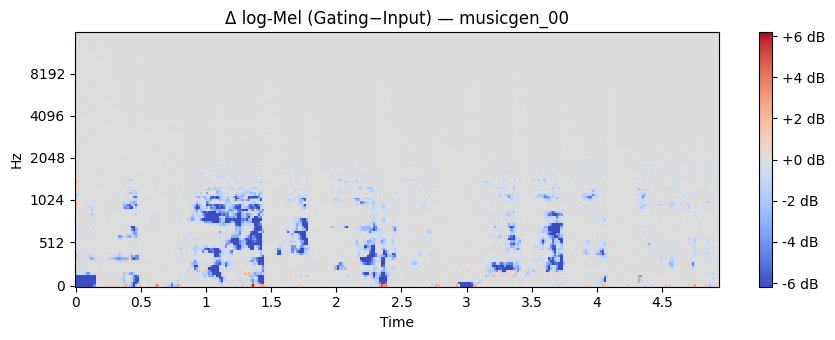

[OK] Salvato: restored_outputs/delta_spectrograms/musicgen_01_delta_demucs.png


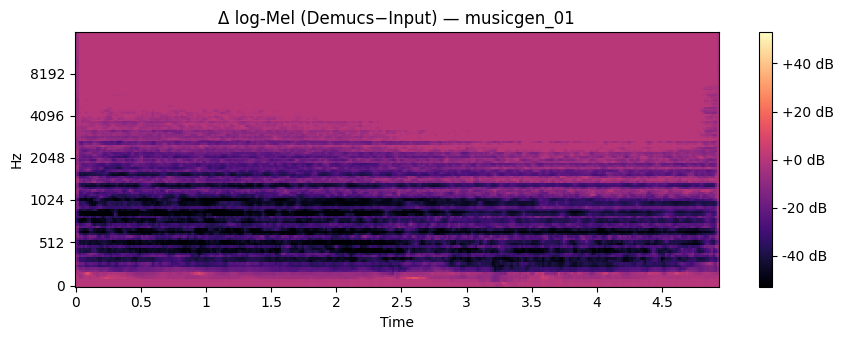

[OK] Salvato: restored_outputs/delta_spectrograms/musicgen_01_delta_gating.png


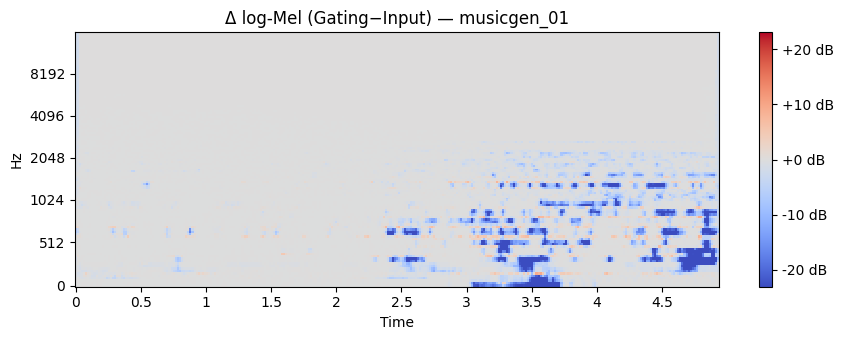

[OK] Salvato: restored_outputs/delta_spectrograms/musicgen_02_delta_demucs.png


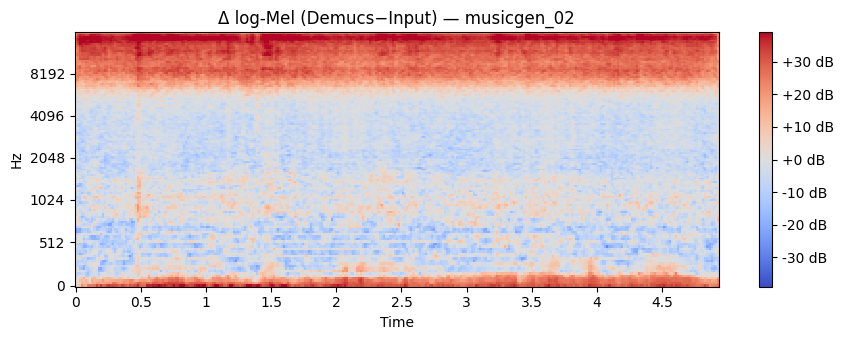

[OK] Salvato: restored_outputs/delta_spectrograms/musicgen_02_delta_gating.png


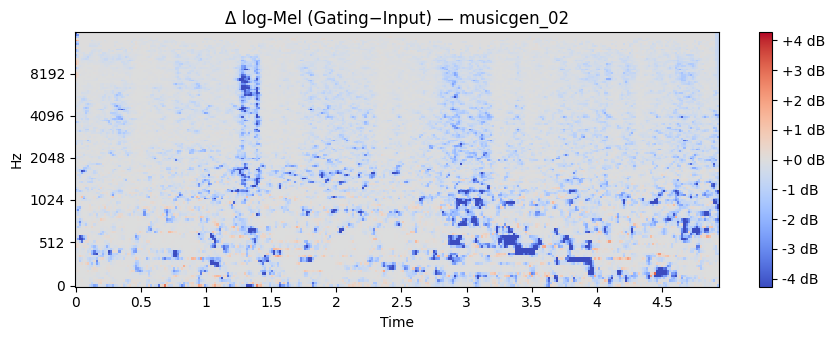

,file,method,ΔHBER_dB,Flatness,NoiseFloor_dB
0,musicgen_00.wav,Demucs,-11.090,0.000,-54.488
1,musicgen_00.wav,Gating,0.970,0.000,NaN
2,musicgen_01.wav,Demucs,-4.229,0.000,NaN
3,musicgen_01.wav,Gating,-0.620,0.000,NaN
4,musicgen_02.wav,Demucs,-21.732,0.051,NaN
5,musicgen_02.wav,Gating,0.057,0.001,NaN


Salvato: results_musicgen_demucs_vs_gating_proxy.csv


In [38]:

# Questa funzione implementa l'algoritmo di Spectral Gating una tecnica di riduzione del rumore.
def spectral_gating(x, n_fft=1024, hop=256, perc=10, k=1.5, length=None):
    S = librosa.stft(x, n_fft=n_fft, hop_length=hop)  # Calcola la STFT del segnale audio `x`
    mag = np.abs(S)  # Ottiene la magnitudine dello spettrogramma
    noise = np.percentile(mag, perc, axis=1, keepdims=True)  # Stima il livello di rumore
    thr = k * noise  # Calcola una soglia di rumore
    mask = (mag > thr).astype(float)  # Crea una maschera : 1 se la magnitudine supera la soglia, 0 altrimenti.
    Y = mask * S  # Applica la maschera allo spettrogramma complesso per rimuovere il rumore
    y = librosa.istft(Y, hop_length=hop)  # Ricostruisce il segnale audio dal nuovo spettrogramma
    if length is not None:
        y = librosa.util.fix_length(y, length)
    return y

# Questa funzione rende visibile la differenza tra lo spettrogramma Mel dell'audio di output e quello dell'input
def plot_delta_spectrogram_db(input_path, output_path, out_png=None, sr=32000,
                             n_mels=128, fmax=16000,
                             title_prefix="Δ log-Mel (out−in)"):
    """Mostra la differenza tra log-Mel dell'output e dell'input (OUT_dB − IN_dB)."""
    # Carica mono e allinea lunghezze
    xin,  _ = librosa.load(input_path,  sr=sr, mono=True)
    xout, _ = librosa.load(output_path, sr=sr, mono=True)
    n = min(len(xin), len(xout))
    xin, xout = xin[:n], xout[:n]

    # Mel-spectrogrammi (potenza) e in dB
    S_in  = librosa.feature.melspectrogram(y=xin,  sr=sr, n_mels=n_mels, fmax=fmax)
    S_out = librosa.feature.melspectrogram(y=xout, sr=sr, n_mels=n_mels, fmax=fmax)
    S_in_db  = librosa.power_to_db(S_in,  ref=np.max)
    S_out_db = librosa.power_to_db(S_out, ref=np.max)

    # Δ log-Mel
    Delta = S_out_db - S_in_db

    # Scala colore simmetrica robusta
    vmax = np.percentile(np.abs(Delta), 99)
    vmin = -vmax if vmax > 0 else -1

    # Plot
    fig, ax = plt.subplots(figsize=(9, 3.5))
    img = librosa.display.specshow(Delta, x_axis="time", y_axis="mel",
                                   sr=sr, fmax=fmax, ax=ax, vmin=vmin, vmax=vmax)
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    clip = Path(input_path).stem
    ax.set_title(f"{title_prefix} — {clip}")
    plt.tight_layout()

    # Salvataggio
    if out_png:
        out_png = Path(out_png)
        out_png.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(out_png, dpi=150, bbox_inches="tight")
        print(f"[OK] Salvato: {out_png}")
    plt.show()

# Cartella per salvare la baseline
baseline_dir = Path("restored_outputs/baseline_gating"); baseline_dir.mkdir(parents=True, exist_ok=True)

rows = []
for rec in mg_records:
    in_path  = Path(rec["file"])
    dem_path = Path(rec["restored"])
    if not in_path.exists() or not dem_path.exists():
        continue

    xin, sr = librosa.load(in_path, sr=32000, mono=True)
    xdem,_  = librosa.load(dem_path, sr=32000, mono=True)

    # Baseline: spectral gating sull'input MusicGen
    xgat = spectral_gating(xin)
    out_gat_path = baseline_dir / f"{in_path.stem}_gating.wav"
    sf.write(out_gat_path, np.clip(xgat, -1.0, 1.0), sr, subtype="PCM_16")

    # Metriche proxy per Demucs e Gating
    for name, xout in [("Demucs", xdem), ("Gating", xgat)]:
        rows.append({
            "file": in_path.name,
            "method": name,
            "ΔHBER_dB": highband_energy_gain(xin, xout, sr=sr, f_cut=7000),
            "Flatness": spectral_flatness_mean(xout, sr),
            "NoiseFloor_dB": silence_noise_floor(xout, sr)
        })

    # Delta spectrogram (log-Mel) per entrambe le uscite
    plot_delta_spectrogram_db(str(in_path), str(dem_path),
                              out_png=f"restored_outputs/delta_spectrograms/{in_path.stem}_delta_demucs.png",
                              title_prefix="Δ log-Mel (Demucs−Input)")
    plot_delta_spectrogram_db(str(in_path), str(out_gat_path),
                              out_png=f"restored_outputs/delta_spectrograms/{in_path.stem}_delta_gating.png",
                              title_prefix="Δ log-Mel (Gating−Input)")

df_cmp = pd.DataFrame(rows).round(3)
display(df_cmp)
df_cmp.to_csv("results_musicgen_demucs_vs_gating_proxy.csv", index=False)
print("Salvato: results_musicgen_demucs_vs_gating_proxy.csv")


##  **Conclusioni**
In conclusione, questo progetto ha dimostrato l'utilità di una pipeline di restauro zero-shot basata su Demucs, rivelando un miglioramento del segnale audio nelle alte frequenze e al tempo stesso delle difficoltà nel restauro di audio complessi, soprattutto nelle bassse frequenze. La baseline basata sullo Spectral Gating è risultata soddisfacente tuttavia può portare all'eliminazioni di segnali utili e all'inserimento di nuovi rumori. Demucs ha quindi mostrato una migliore efficienza nel riconoscere rumore e segnale utile (segnale musicale), usando la separazione delle sorgenti.